In [2]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 5.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
%cd /content/drive/MyDrive/EXIST 2024

/content/drive/.shortcut-targets-by-id/1fzXIAVDRwaKW1f_4_eLs4yvd0zctvLzz/EXIST 2024


In [4]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import pipeline, XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import random

In [5]:
GLOBAL_SEED = 255

np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
torch.use_deterministic_algorithms(True)
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [6]:
train_df = pd.read_json('./Data/EXIST 2024 Tweets Dataset/training/EXIST2024_training.json').transpose()
dev_df = pd.read_json('./Data/EXIST 2024 Tweets Dataset/dev/EXIST2024_dev.json').transpose()
test_df = pd.read_json('./Data/EXIST 2024 Tweets Dataset/test/EXIST2023_test_clean.json').transpose()

In [7]:
label2id = {'NO': 0, 'YES': 1}
id2label = {0: 'NO', 1: 'YES'}

def preprocess(df):
  df['predicted_label'] = df['labels_task1'].apply(lambda x: 1 if x.count('YES') >= x.count('NO') else 0)
  for column_name in ['number_annotators', 'annotators', 'gender_annotators', 'age_annotators', 'ethnicities_annotators', 'study_levels_annotators', 'countries_annotators', 'split']:
    if column_name in df.columns:
      df.drop(column_name, axis=1, inplace=True)


In [8]:
preprocess(train_df)
preprocess(dev_df)

In [9]:
train_df

,id_EXIST,lang,tweet,labels_task1,labels_task2,labels_task3,predicted_label
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",1
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,"[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",0
100003,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",0
100004,100004,es,@Lunariita7 Un retraso social bastante lamenta...,"[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",1
100005,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,"[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",1
...,...,...,...,...,...,...,...
203256,203256,en,idk why y’all bitches think having half your a...,"[YES, YES, YES, YES, YES, YES]","[JUDGEMENTAL, DIRECT, DIRECT, DIRECT, JUDGEMEN...","[[OBJECTIFICATION], [STEREOTYPING-DOMINANCE, S...",1
203257,203257,en,This has been a part of an experiment with @Wo...,"[YES, YES, YES, YES, YES, YES]","[JUDGEMENTAL, REPORTED, JUDGEMENTAL, DIRECT, J...","[[OBJECTIFICATION], [OBJECTIFICATION], [OBJECT...",1
203258,203258,en,"""Take me already"" ""Not yet. You gotta be ready...","[NO, YES, NO, YES, YES, YES]","[-, DIRECT, -, DIRECT, DIRECT, JUDGEMENTAL]","[[-], [OBJECTIFICATION], [-], [SEXUAL-VIOLENCE...",1
203259,203259,en,@clintneedcoffee why do you look like a whore?...,"[YES, YES, YES, YES, YES, YES]","[DIRECT, DIRECT, DIRECT, DIRECT, JUDGEMENTAL, ...","[[OBJECTIFICATION, SEXUAL-VIOLENCE, MISOGYNY-N...",1


<ipython-input-32-dd73b5488927>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(train_df, x='predicted_label', y='lang', inner='box', palette='Dark2')


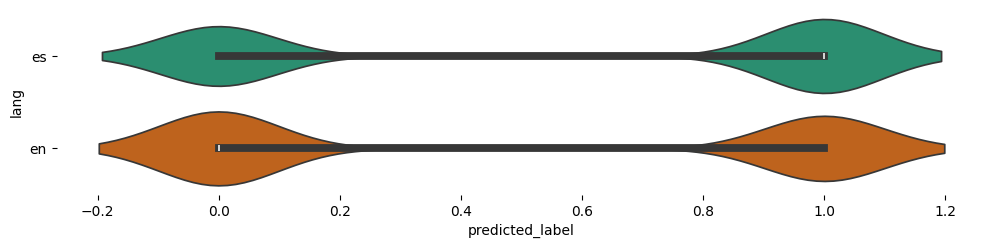

In [ ]:
# @title lang vs predicted_label

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(train_df['lang'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(train_df, x='predicted_label', y='lang', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

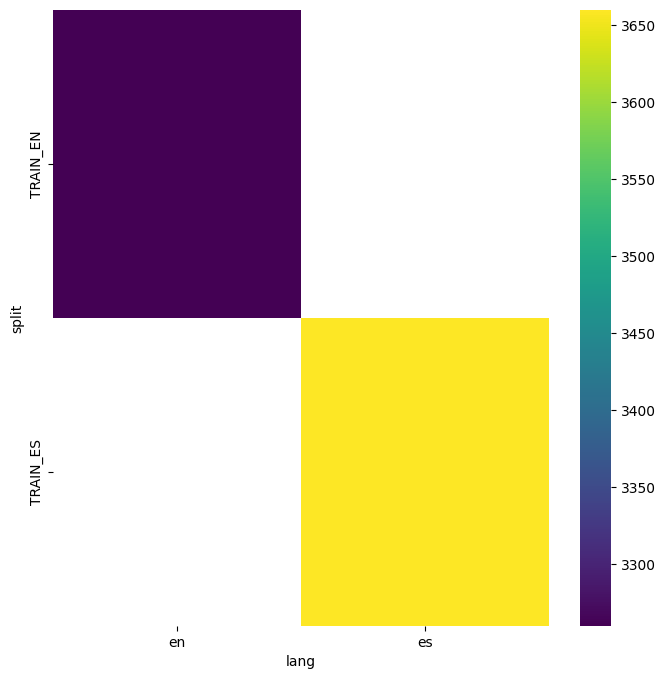

In [ ]:
# @title lang vs split

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['split'].value_counts()
    for x_label, grp in train_df.groupby('lang')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('lang')
_ = plt.ylabel('split')

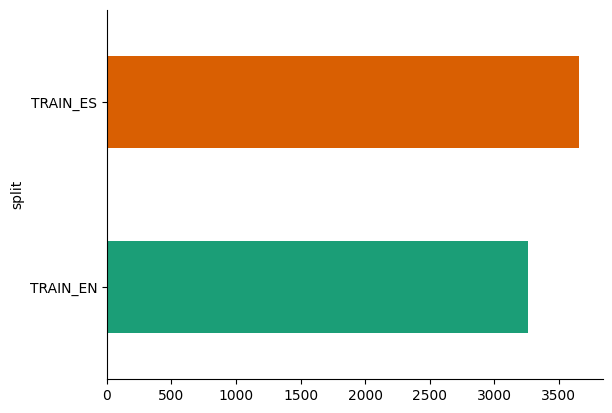

In [ ]:
# @title split

from matplotlib import pyplot as plt
import seaborn as sns
train_df.groupby('split').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

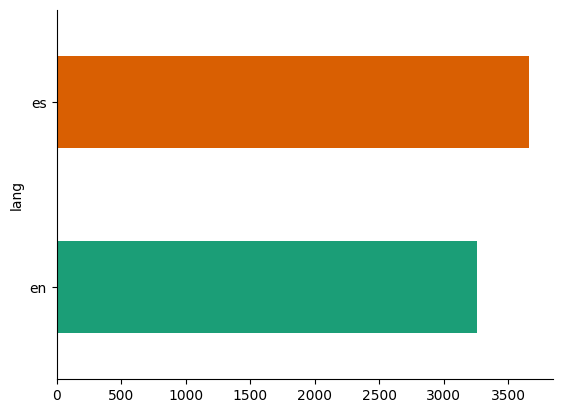

In [ ]:
# @title lang

from matplotlib import pyplot as plt
import seaborn as sns
train_df.groupby('lang').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

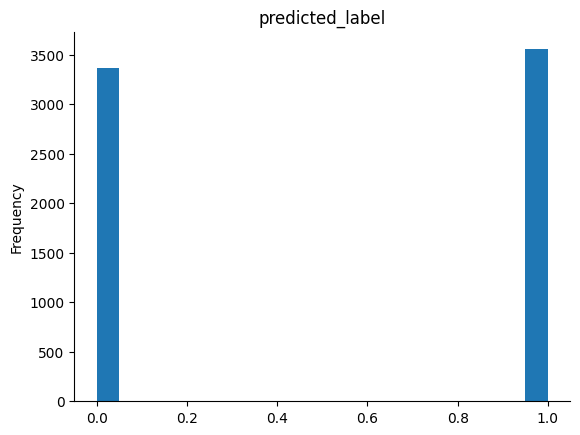

In [ ]:
# @title predicted_label

from matplotlib import pyplot as plt
train_df['predicted_label'].plot(kind='hist', bins=20, title='predicted_label')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
train_df

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,ethnicities_annotators,study_levels_annotators,countries_annotators,labels_task1,labels_task2,labels_task3,split,predicted_label
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[White or Caucasian, Hispano or Latino, White ...","[Bachelor’s degree, Bachelor’s degree, High sc...","[Italy, Mexico, United States, Spain, Spain, C...","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES,1
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[Black or African American, Hispano or Latino,...","[High school degree or equivalent, Bachelor’s ...","[United Kingdom, Mexico, United States, Portug...","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES,0
100003,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[Black or African American, Hispano or Latino,...","[High school degree or equivalent, Bachelor’s ...","[United Kingdom, Mexico, United States, Portug...","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES,0
100004,100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[Hispano or Latino, Hispano or Latino, White o...","[High school degree or equivalent, Bachelor’s ...","[Mexico, Chile, Spain, Spain, Portugal, Spain]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES,1
100005,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[Hispano or Latino, Hispano or Latino, White o...","[Bachelor’s degree, Bachelor’s degree, Master’...","[Mexico, Afghanistan, United States, Italy, Po...","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203256,203256,en,idk why y’all bitches think having half your a...,6,"[Annotator_478, Annotator_479, Annotator_480, ...","[F, F, M, M, M, F]","[18-22, 23-45, 18-22, 23-45, 46+, 46+]","[White or Caucasian, Black or African American...","[High school degree or equivalent, Bachelor’s ...","[Hungary, South Africa, Chile, Portugal, Unite...","[YES, YES, YES, YES, YES, YES]","[JUDGEMENTAL, DIRECT, DIRECT, DIRECT, JUDGEMEN...","[[OBJECTIFICATION], [STEREOTYPING-DOMINANCE, S...",TRAIN_EN,1
203257,203257,en,This has been a part of an experiment with @Wo...,6,"[Annotator_668, Annotator_669, Annotator_670, ...","[F, F, M, M, M, F]","[18-22, 23-45, 18-22, 23-45, 46+, 46+]","[Hispano or Latino, other, White or Caucasian,...","[High school degree or equivalent, Master’s de...","[Mexico, Algeria, Portugal, Spain, United King...","[YES, YES, YES, YES, YES, YES]","[JUDGEMENTAL, REPORTED, JUDGEMENTAL, DIRECT, J...","[[OBJECTIFICATION], [OBJECTIFICATION], [OBJECT...",TRAIN_EN,1
203258,203258,en,"""Take me already"" ""Not yet. You gotta be ready...",6,"[Annotator_467, Annotator_468, Annotator_469, ...","[F, F, M, M, M, F]","[18-22, 23-45, 18-22, 23-45, 46+, 46+]","[White or Caucasian, White or Caucasian, White...","[High school degree or equivalent, Bachelor’s ...","[Poland, Poland, Portugal, Canada, United King...","[NO, YES, NO, YES, YES, YES]","[-, DIRECT, -, DIRECT, DIRECT, JUDGEMENTAL]","[[

In [10]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [11]:
def load_model_and_tokenizer(model_name, number_of_labels):
  # Initialize tokenizer and model
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  #model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = number_of_labels, device_map = 'auto')
  model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = number_of_labels)

  return model, tokenizer

def train_model(model, tokenizer, train_df, val_df, id2label, batch_size = 8, number_of_epochs = 3, learning_rates = [1e-5, 1e-5, 1e-5], weight_decay = 0.01):

  # Move the model to GPU
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  # Create datasets and dataloaders
  train_dataset = CustomDataset(train_df['tweet'].values, train_df['predicted_label'].values, tokenizer)
  val_dataset = CustomDataset(val_df['tweet'].values, val_df['predicted_label'].values, tokenizer)

  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  # Training loop (optional if you have labeled data)
  # Skip this part if you're doing zero-shot learning

  # Define early stopping
  best_val_loss = np.Inf
  patience = 3
  early_stopping_counter = 0

  # Train the model
  for epoch in range(number_of_epochs):
      # Define optimizer and loss function
      optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rates[epoch], weight_decay=weight_decay)
      total_steps = len(train_dataloader) * number_of_epochs
      scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
      model.train()
      total_train_loss = 0
      total_train_correct = 0
      total_train_samples = 0

      for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        total_train_correct += (preds == labels).sum().item()
        total_train_samples += labels.shape[0]

        loss.backward()
        optimizer.step()
        scheduler.step()

      train_loss = total_train_loss / len(train_dataloader)
      train_acc = total_train_correct / total_train_samples


      # Evaluation for this epoch
      model.eval()
      val_losses = []
      total_dev_loss = 0
      total_dev_correct = 0
      total_dev_samples = 0

      for batch in tqdm(val_dataloader):
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['labels'].to(device)

          with torch.no_grad():
              outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
              val_losses.append(outputs.loss.item())

          loss = outputs.loss
          total_dev_loss += loss.item()

          preds = torch.argmax(outputs.logits, dim=1)
          total_dev_correct += (preds == labels).sum().item()
          total_dev_samples += labels.shape[0]

      avg_val_loss = np.mean(val_losses)

      dev_loss = total_dev_loss / len(val_dataloader)
      dev_acc = total_dev_correct / total_dev_samples

      print(f'Epoch {epoch+1}/{number_of_epochs}')
      print(f'Train loss {train_loss}, accuracy {train_acc}')
      print(f'Dev loss {dev_loss}, accuracy {dev_acc}')

  # Load the best model
  return model, tokenizer

def Evaluate(model, tokenizer, val_df, id2label, batch_size = 8):

  # Move the model to GPU
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  # Create datasets and dataloaders
  val_dataset = CustomDataset(val_df['tweet'].values, val_df['predicted_label'].values, tokenizer)

  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  # Evaluation
  model.eval()
  all_preds = []
  all_labels = []

  for batch in val_dataloader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      with torch.no_grad():
          outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

      logits = outputs.logits
      preds = torch.argmax(logits, dim=1).cpu().numpy()

      all_preds.extend(preds)
      all_labels.extend(labels.cpu().numpy())

  # Convert numerical labels back to text labels
  predicted_labels = [id2label[label] for label in all_preds]
  true_labels = [id2label[label] for label in all_labels]

  # Print classification report
  print(classification_report(true_labels, predicted_labels))
  return predicted_labels


In [12]:
from google.colab import userdata

def login2HF():
  !huggingface-cli login --token '{userdata.get('HF_token')}'

In [13]:
login2HF()

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [14]:
def save_and_upload(model, tokenizer, model_name2save):

  model.save_pretrained(model_name2save)
  tokenizer.save_pretrained(model_name2save)

In [21]:
roberta_large_model, roberta_large_tokenizer = load_model_and_tokenizer('xlm-roberta-large', 2)
roberta_large_model, roberta_large_tokenizer = train_model(roberta_large_model, roberta_large_tokenizer, train_df, dev_df, id2label, batch_size=16, number_of_epochs=3, learning_rates=[2e-5, 1e-5, 1e-5], weight_decay=0.03)
predicted_labels = Evaluate(roberta_large_model, roberta_large_tokenizer, dev_df, id2label, batch_size = 16)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 65/65 [00:24<00:00,  2.63it/s]


Epoch 1/3
Train loss 0.5524892833161299, accuracy 0.7095375722543352
Dev loss 0.41632817605367073, accuracy 0.8131021194605009


100%|██████████| 65/65 [00:24<00:00,  2.60it/s]


Epoch 2/3
Train loss 0.39135003530401, accuracy 0.8281791907514451
Dev loss 0.4130958685508141, accuracy 0.8198458574181118


100%|██████████| 65/65 [00:24<00:00,  2.65it/s]


Epoch 3/3
Train loss 0.32815945119216317, accuracy 0.8624277456647399
Dev loss 0.41415882741029447, accuracy 0.8314065510597303
              precision    recall  f1-score   support

          NO       0.80      0.85      0.82       479
         YES       0.87      0.81      0.84       559

    accuracy                           0.83      1038
   macro avg       0.83      0.83      0.83      1038
weighted avg       0.83      0.83      0.83      1038



In [ ]:
combined_data = pd.concat([train_df, dev_df], ignore_index=True)

In [ ]:
# Perform cross-validation
scores = cross_val_score(model, X, y, cv=5)  # 5-fold cross-validation

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

In [17]:
roberta_large_model, roberta_large_tokenizer = load_model_and_tokenizer('am-azadi/EXIST2024_Task1_xlmRoberta_large_3_16', 2)
roberta_large_model, roberta_large_tokenizer = train_model(roberta_large_model, roberta_large_tokenizer, train_df, dev_df, id2label, batch_size=16, number_of_epochs=3, learning_rates=[5e-6, 3e-6, 2e-6], weight_decay=0.1)
predicted_labels = Evaluate(roberta_large_model, roberta_large_tokenizer, dev_df, id2label, batch_size = 16)

100%|██████████| 65/65 [00:24<00:00,  2.61it/s]


Epoch 1/2
Train loss 0.23866011971052883, accuracy 0.9030346820809249
Dev loss 0.4910171703650401, accuracy 0.8198458574181118


100%|██████████| 65/65 [00:25<00:00,  2.59it/s]


Epoch 2/2
Train loss 0.17625546146949914, accuracy 0.9333815028901734
Dev loss 0.5423467778099271, accuracy 0.8246628131021194
              precision    recall  f1-score   support

          NO       0.78      0.86      0.82       479
         YES       0.87      0.79      0.83       559

    accuracy                           0.82      1038
   macro avg       0.83      0.83      0.82      1038
weighted avg       0.83      0.82      0.82      1038



In [22]:
save_and_upload(roberta_large_model, roberta_large_tokenizer, 'EXIST2024_Task1_xlmRoberta_large_3_16')
!huggingface-cli upload 'EXIST2024_Task1_xlmRoberta_large_3_16'

Consider using `hf_transfer` for faster uploads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
model.safetensors: 100% 2.24G/2.24G [00:51<00:00, 43.4MB/s]
https://huggingface.co/am-azadi/EXIST2024_Task1_xlmRoberta_large_3_16/tree/main/.


In [15]:
roberta_large_model, roberta_large_tokenizer = load_model_and_tokenizer('am-azadi/EXIST2024_Task1_xlmRoberta_large_3_16', 2)
predicted_labels = Evaluate(roberta_large_model, roberta_large_tokenizer, dev_df, id2label, batch_size = 16)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

              precision    recall  f1-score   support

          NO       0.77      0.87      0.82       479
         YES       0.87      0.78      0.83       559

    accuracy                           0.82      1038
   macro avg       0.82      0.83      0.82      1038
weighted avg       0.83      0.82      0.82      1038



In [17]:
def get_mislabeled_sentences(df, predicted_labels):
  filtered_df = df
  filtered_df['model_label'] = predicted_labels
  filtered_df['predicted_label'] = filtered_df['predicted_label'].map(id2label)
  filtered_df = filtered_df[filtered_df['predicted_label'] != predicted_labels]
  return filtered_df

In [19]:
filtered_df = get_mislabeled_sentences(dev_df, predicted_labels)
print(len(filtered_df))

184


In [21]:
filtered_df[filtered_df['lang'] == 'en']

,id_EXIST,lang,tweet,labels_task1,labels_task2,labels_task3,predicted_label,model_label
400001,400001,en,"@Mike_Fabricant “You should smile more, love. ...","[NO, NO, NO, NO, YES, YES]","[-, -, -, -, REPORTED, DIRECT]","[[-], [-], [-], [-], [IDEOLOGICAL-INEQUALITY, ...",NO,YES
400008,400008,en,@ReproRights @AbortionStories Getting Twitter ...,"[NO, YES, NO, YES, YES, YES]","[-, REPORTED, -, DIRECT, JUDGEMENTAL, DIRECT]","[[-], [OBJECTIFICATION, SEXUAL-VIOLENCE], [-],...",YES,NO
400010,400010,en,@punishedmother There could be an opportunity ...,"[YES, NO, NO, YES, NO, YES]","[DIRECT, -, -, DIRECT, -, JUDGEMENTAL]","[[IDEOLOGICAL-INEQUALITY], [-], [-], [IDEOLOGI...",YES,NO
400016,400016,en,@avalikia @Xoriginalname @SunUnderstander @UwU...,"[YES, YES, NO, NO, NO, YES]","[JUDGEMENTAL, REPORTED, -, -, -, REPORTED]","[[IDEOLOGICAL-INEQUALITY, STEREOTYPING-DOMINAN...",YES,NO
400019,400019,en,West Yorkshire Police are committed to tacklin...,"[NO, YES, YES, YES, NO, NO]","[-, JUDGEMENTAL, JUDGEMENTAL, REPORTED, -, -]","[[-], [SEXUAL-VIOLENCE], [OBJECTIFICATION, SEX...",YES,NO
...,...,...,...,...,...,...,...,...
400449,400449,en,"@CrossrdsCMG Yeah, women are getting just as b...","[NO, NO, NO, NO, NO, YES]","[-, -, -, -, -, REPORTED]","[[-], [-], [-], [-], [-], [STEREOTYPING-DOMINA...",NO,YES
400468,400468,en,women shouldn’t have to share their trauma sto...,"[NO, YES, YES, NO, NO, NO]","[-, REPORTED, JUDGEMENTAL, -, -, -]","[[-], [IDEOLOGICAL-INEQUALITY], [STEREOTYPING-...",NO,YES
400474,400474,en,#cryptosterone 👈All-new!Twice as many #men inv...,"[NO, NO, NO, YES, NO, NO]","[-, -, -, DIRECT, -, -]","[[-], [-], [-], [IDEOLOGICAL-INEQUALITY, STERE...",NO,YES
400481,400481,en,"Uh, they're allowed to? calling this out makes...","[NO, NO, YES, NO, YES, NO]","[-, -, JUDGEMENTAL, -, DIRECT, -]","[[-], [-], [MISOGYNY-NON-SEXUAL-VIOLENCE], [-]...",NO,YES
